# Homework 6

## Question 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings('ignore')

### 1. Read the csv file from the URL and set the first column in the data as the index column.

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/US_macro_Quarterly.csv')
df.set_index(df.columns[0], inplace=True)
df.index.name = 'date'
df.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
date,,,,,,,,,,,,
1959-03-31,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### 2. Before moving forward, we first need to change the data frame index type into "datetime"?

In [3]:
df.index = pd.to_datetime(df.index).to_period('Q')
df.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
date,,,,,,,,,,,,
1959Q1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959Q2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959Q3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959Q4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960Q1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### 3. Our variable of interest is "cpi" which stands for consumer price index. Keep this variable in the data and drop the rest.

In [4]:
df = df[['cpi']]
df.head()

,cpi
date,
1959Q1,28.98
1959Q2,29.15
1959Q3,29.35
1959Q4,29.37
1960Q1,29.54


### 4. Using Matplotlib, plot the time series for cpi. As you can see, the cpi data is NOT stationary because there is a clear upward trend in the cpi data. Using Deep Neural Networks (DNN), do you think we need to de-trend the cpi data and make it stationary? what are the advantages and disadvantages?

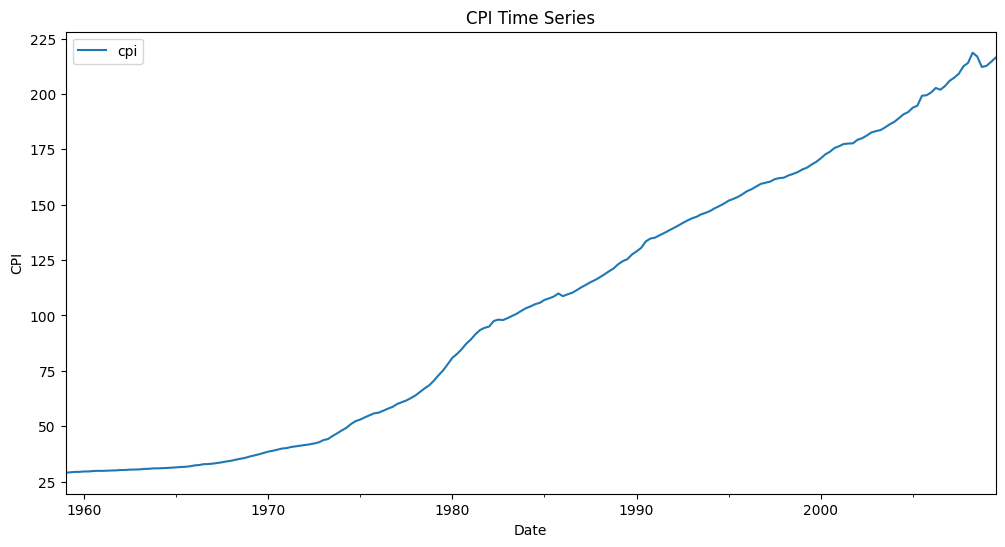

In [5]:
df.plot(figsize=(12,6))
plt.title('CPI Time Series')
plt.grid(visible=False)
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

4. (Answer) - I don't think we need to te-trend/de-seasonalize our data, since Deep neural networks can handle the complex relationships, at least if the model is complex enough. The pros for de-trending/de-seasonalizing the data are that we could get away with a less complex model, but the cons are that it would take time to de-trend/de-seasonalize the data, and frankly it is unnecessary. For that reason we will not be doing that here.

### 5. Prepare your dataset for a supervised deep learning task.

1. test_period = 24. Plot the train-test data to get a sense of what you are going to do for forecasts.
2. Tx = 8 (using the past 2 years (8 quarters) of data to make a forecast for next quarter)
3. Ty=1 (for one-step ahead forecast) and once needed, Ty=24 (for multi output forecast)
4. At the end of this step, your X and y shapes should be X: (195, 8) Y: (195, 1)

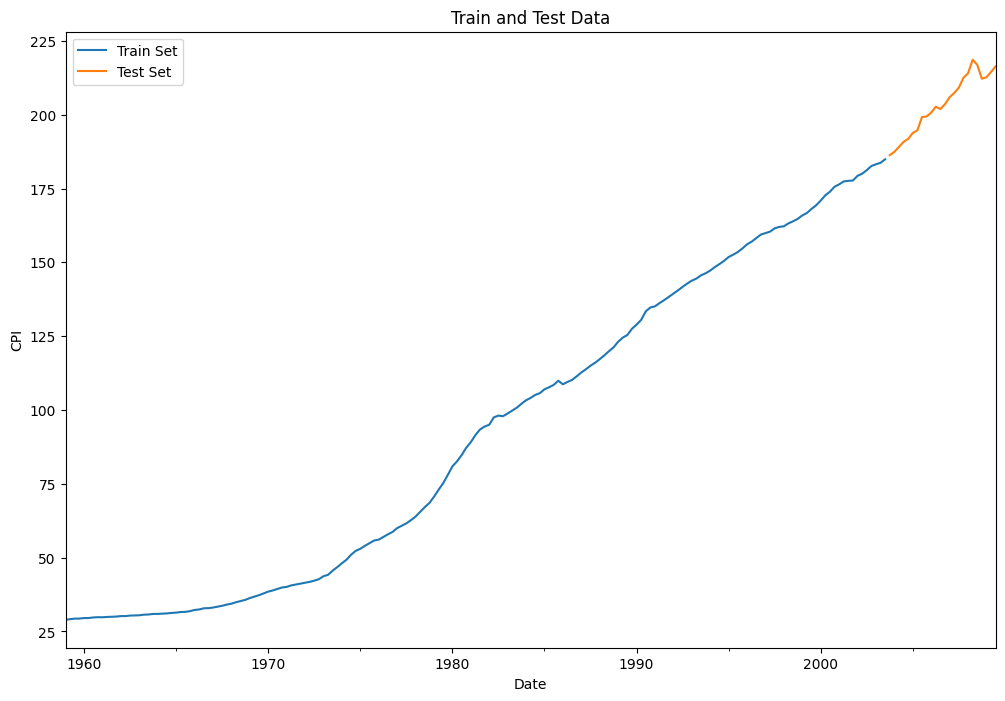

In [6]:
test_period = 24
train_period = len(df) - test_period

train = df.iloc[:train_period]
test = df.iloc[train_period:]

train_indicator = (df.index <= train.index[-1])
test_indicator =  (df.index > train.index[-1])

df.loc[train_indicator, 'train_set'] = df.loc[train_indicator, 'cpi']
df.loc[test_indicator, 'test_set'] = df.loc[test_indicator, 'cpi']

df[['train_set', 'test_set']].plot(figsize=(12, 8))
plt.title('Train and Test Data')
plt.legend(['Train Set', 'Test Set'])
plt.grid(visible=False)
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

In [7]:
train_indicator = (df.index <= train.index[-1])
test_indicator =  (df.index > train.index[-1])

series = df['cpi'].dropna().to_numpy()

Tx = 8
Ty = 1
X = np.array([series[t:t+Tx] for t in range(len(series) - Tx-Ty+1)])
Y = np.array([series[t+Tx: t+Tx+Ty] for t in range(len(series) - Tx-Ty+1)])

train_indicator[:Tx] = False
print("X:", X.shape, "Y:", Y.shape)

X: (195, 8) Y: (195, 1)


### 6. Split the data into Xtrain, Ytrain, Xtest and Ytest using test_period=24

In [8]:
X_train, Y_train = X[:-test_period], Y[:-test_period]
X_test, Y_test = X[-test_period:], Y[-test_period:]

print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("X_test:", X_test.shape, "Y_test:", Y_test.shape)

X_train: (171, 8) Y_train: (171, 1)
X_test: (24, 8) Y_test: (24, 1)


### 7. Create your very first DNN model. Feel free to try out any architecture you want with different number of hidden layers and nodes. Here is what you can use for starters:

1. Two hidden layers with 32 and 16 nodes respectively. For this example, why it is NOT recommended to use less than 8 nodes in the first hidden layer?
2. Activation functions for the hidden layers can be both "ReLU". In this example, for the output layer you can use either "linear" or "ReLU". why? 
3. Loss and metric should be both "mse". 

In [9]:
def build_model(Tx, Ty):
    i = Input(shape=(Tx,))
    x = Dense(32, activation='relu')(i)
    x = Dense(16, activation='relu')(x)
    output = Dense(Ty , activation = 'linear')(x)
    model = Model(i, output)
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

7. (Answers) - 1) If we use less than 8 (the number of features we have), then we will create a bottleneck. 2) We can use either ReLU or linear activation functions, since we are dealing with a regression task, and the values cannot be less than 0, so linear and ReLU will be identical.

### 8. Build the model and report the model.summary(). How many trainable parameters does your model have? explain in details how you can calculate the number of parameters for each layer.

In [10]:
model = build_model(Tx, Ty)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833 (3.25 KB)

 Trainable params: 833 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

8. (Answer) - The model has 833 total trainable parameters. You can easily calculate the number of parameters by multiplying the shapes of consequtive layers together, and adding them together. In this case we take our input shape (8) and multiply it by the 32 nodes in our first layer to get 256 weights. Saving this for later, we next multiply the 32 nodes in the first layer by the 16 nodes in the second layer, giving us 512 weights. Finally we take the 16 nodes of the second layer and multiply them by the single output node, giving us 16 weights. Each node also has a bias term, so we take the 256 + 512 + 16 weights and add 32 + 16 + 1 biases to get 833 total parameters.

### 9. Train the model with 100 epochs and batch_size=16. Also add this callback to your fit argument: `EarlyStopping(monitor='val_loss', patience=10)`.

In [11]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=16, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 19971.3867 - mse: 19971.3867 - val_loss: 45598.0742 - val_mse: 45598.0742
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11627.0557 - mse: 11627.0557 - val_loss: 24849.5781 - val_mse: 24849.5781
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5249.4971 - mse: 5249.4971 - val_loss: 10161.5654 - val_mse: 10161.5654
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2272.0798 - mse: 2272.0798 - val_loss: 2260.9788 - val_mse: 2260.9788
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 475.9955 - mse: 475.9955 - val_loss: 54.0726 - val_mse: 54.0726
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.1967 - mse: 15.1967 - val_loss: 151.7066 - val_mse: 151.7066
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45.0005 - mse: 45.0005 - val_loss: 144.2343 - val_mse: 144.2343
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27.6181 - mse: 27.6181 - val_loss: 28.5299 - v

### 10. Plot the train vs validation loss! at what epoch number, did your model stopped training! why?

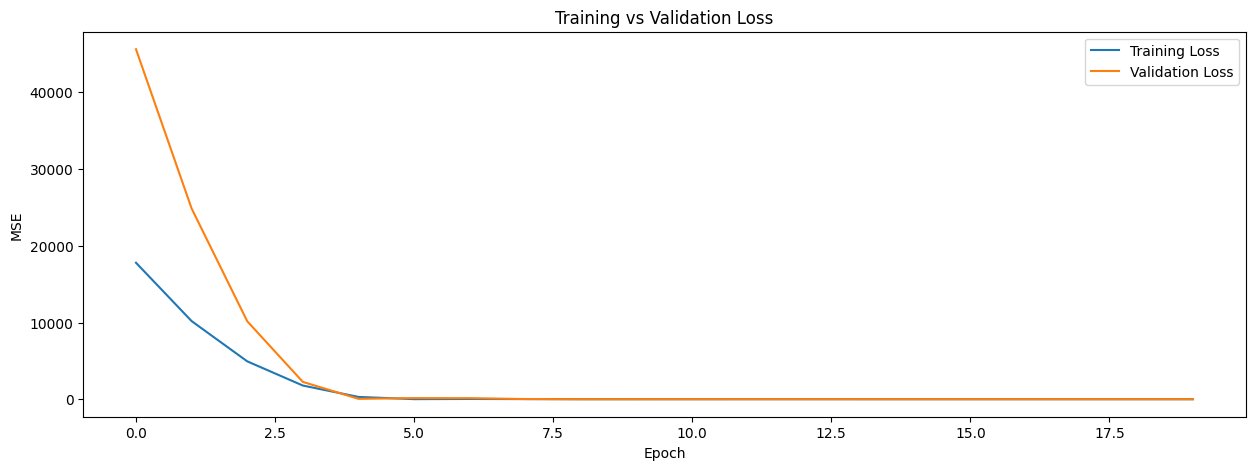

In [12]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot(figsize=(15, 5))
plt.title('Training vs Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid(visible=False)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

10. (Answer) - The model stopped training after around the 18th epoch (I've run this a couple times, and it's always been between 16 and 21, etc.) because the validation loss stopped (noticeably) improving for 10 epochs, thanks to the EarlyStopping callback added.

### 11. Great, you are now ready to make some forecasts:

1. Using your DNN model, make 1-step ahead and multiple step ahead forecasts and add these forecasts to your dataset.

2. Plot the forecasts (both 1-step and multiple-step ahead) for the test set.

In [13]:
DNN_1step_train_forecast = model.predict(X_train)
DNN_1step_test_forecast = model.predict(X_test)

df.loc[train_indicator, '1step_train_forecast'] = DNN_1step_train_forecast
df.loc[test_indicator, '1step_test_forecast'] = DNN_1step_test_forecast

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [14]:
multistep_predictions = []
input_X = X_test[0]

while len(multistep_predictions) < test_period:
  prediction = model.predict(input_X.reshape(1, -1))[0]
  multistep_predictions.append(prediction)

  input_X = np.roll(input_X, -1)
  input_X[-1] = prediction

df.loc[test_indicator, 'multistep_test_forecast'] = multistep_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


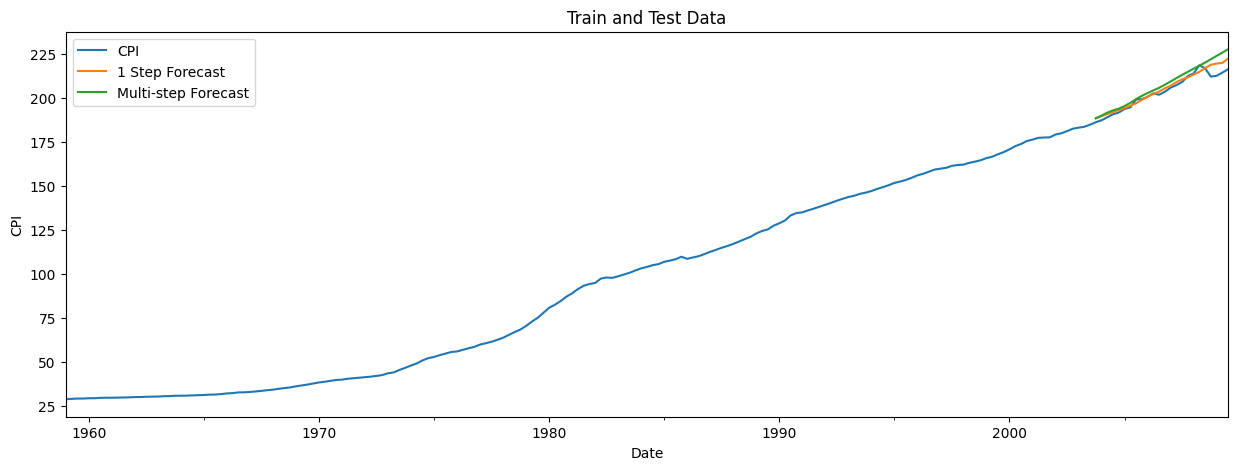

In [15]:
df[['cpi', '1step_test_forecast', 'multistep_test_forecast']].plot(figsize=(15, 5))
plt.title('Forecasts')
plt.title('Train and Test Data')
plt.legend(['CPI', '1 Step Forecast', 'Multi-step Forecast'])
plt.grid(visible=False)
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

### 12. Now let's do multi-output forecasts using `Ty=test_period=24`. Remember, you need to make multi-output supervised dataset first and re-train your model on the new train and validation set. Also make sure you use early stopping callback again: `EarlyStopping(monitor='val_loss', patience=10)`.

In [16]:
Tx = 8
Ty = test_period

X = np.array([series[t:t+Tx] for t in range(len(series) - Tx - Ty+1)])
Y = np.array([series[t+Tx:t+Tx+Ty] for t in range(len(series) - Tx - Ty+1)])

X_train_mo, Y_train_mo = X[:-1], Y[:-1]
X_test_mo, Y_test_mo = X[-1:], Y[-1:]

model_mo = build_model(Tx, Ty)
model_mo.fit(X_train_mo, Y_train_mo, validation_data=(X_test_mo, Y_test_mo), epochs=100, batch_size=16, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11700.0605 - mse: 11700.0605 - val_loss: 29622.7754 - val_mse: 29622.7754
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9636.8281 - mse: 9636.8281 - val_loss: 24758.2871 - val_mse: 24758.2871
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8662.0723 - mse: 8662.0723 - val_loss: 20257.0605 - val_mse: 20257.0605
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6557.0049 - mse: 6557.0049 - val_loss: 16169.1885 - val_mse: 16169.1885
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5754.6504 - mse: 5754.6504 - val_loss: 12401.5498 - val_mse: 12401.5498
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4211.9873 - mse: 4211.9873 - val_loss: 9242.6914 - val_mse: 9242.6914
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2907.1089 - mse: 2907.1089 - val_loss: 6604.6460 - val_mse: 6604.6460
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2088.9192 - mse: 2088.9192

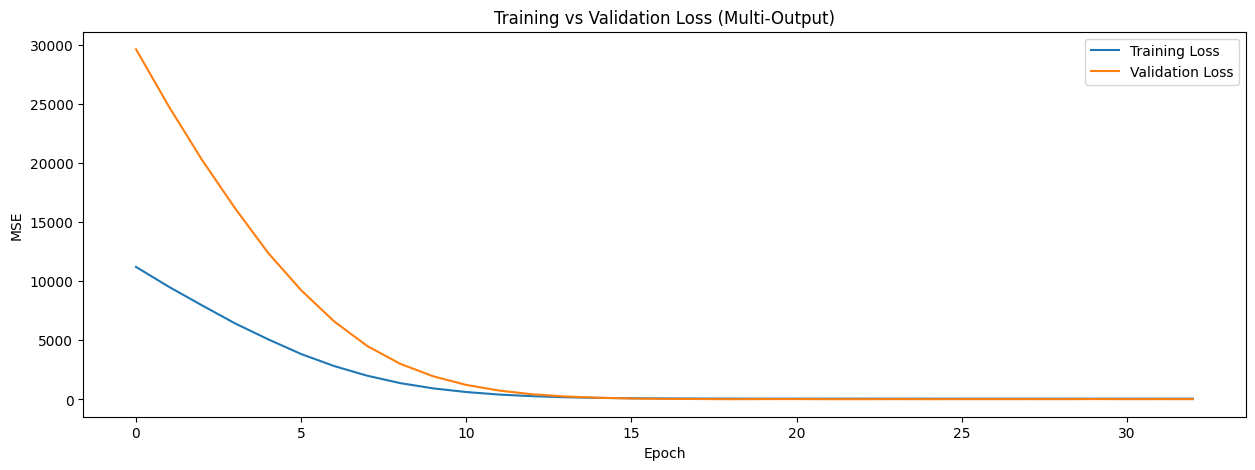

In [17]:
loss_df_mo = pd.DataFrame(model_mo.history.history)
loss_df_mo[['loss', 'val_loss']].plot(figsize=(15, 5))
plt.title('Training vs Validation Loss (Multi-Output)')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid(visible=False)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [18]:
DNN_mo_test_forecast = model_mo.predict(X_test_mo)
df.loc[test_indicator, 'multioutput_test_forecast'] = DNN_mo_test_forecast[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


### 13. Plot all the forecasts (1-step/ multi-step and multiple output) along with the cpi data in the test set only.

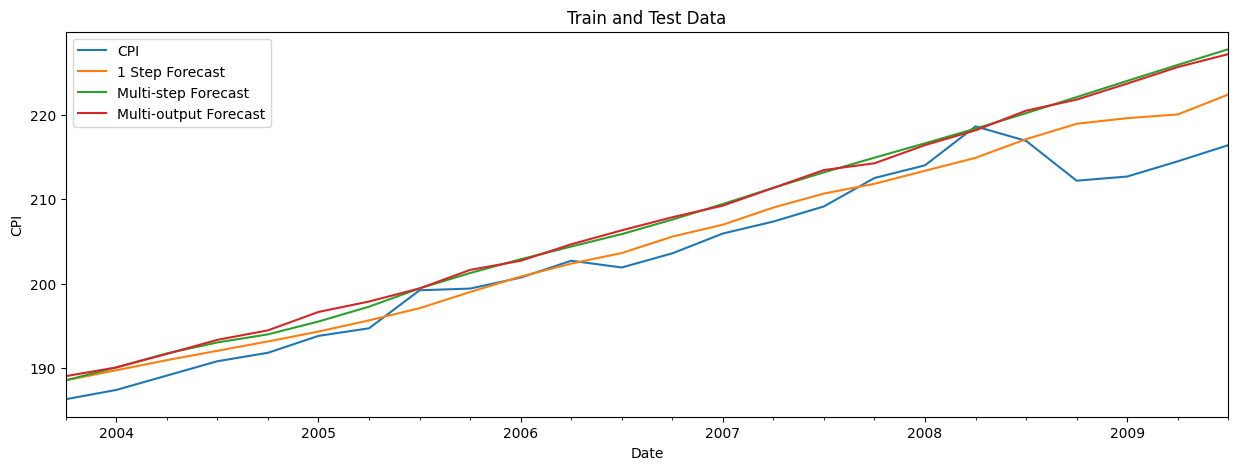

In [19]:
df[['cpi', '1step_test_forecast', 'multistep_test_forecast', 'multioutput_test_forecast']].loc[test_indicator].plot(figsize=(15, 5))
plt.title('Forecasts')
plt.title('Train and Test Data')
plt.legend(['CPI', '1 Step Forecast', 'Multi-step Forecast', 'Multi-output Forecast'])
plt.grid(visible=False)
plt.xlabel('Date')
plt.ylabel('CPI')
plt.show()

### 14. Compare the performance of you DNN model using different forecast types (1-step, multi-step and multiple output) by reporting the MAPE metric for each forecasts types in the test set.

In [20]:
passenger_test = df.loc[test_indicator, 'cpi']
mape_1step = mean_absolute_percentage_error(passenger_test, df.loc[test_indicator, '1step_test_forecast'])
mape_ms = mean_absolute_percentage_error(passenger_test, df.loc[test_indicator, 'multistep_test_forecast'])
mape_mo = mean_absolute_percentage_error(passenger_test, df.loc[test_indicator, 'multioutput_test_forecast'])
print("      1 Step MAPE:", mape_1step)
print("  Multi-step MAPE:", mape_ms)
print("Multi-output MAPE:", mape_mo)

      1 Step MAPE: 0.010446179332579667
  Multi-step MAPE: 0.01895131174120573
Multi-output MAPE: 0.019493642270933934
